In [105]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from enum import Enum
import matplotlib.animation as animation

In [106]:
seed = 1097
rs = np.random.RandomState(seed)

w, h      = 200, 200     # размеры поля
eta       = 0.8          # доля клеток с деревьями
f         = 1            # число изначально горящих деревьев
p_g       = 0.032      # ВАЖНО!!! ВАРИАНТ 2: вероятность роста дерева Меняем 0.008 0.016 0.032
p_f       = 2e-5         # вероятность спонтанного возгорания 
sim_time  = 200          # число шагов моделирования (можно увеличить)
periodic  = True         # периодические границы
neigh     = "cross"      # "cross" = 8 соседей (Мура), "neuman" = 4 соседа (фон-Неймана)

In [107]:
# ========== СОСТОЯНИЯ ==========
class NeighborhoodType(Enum):
    CROSS  = "+"
    NEUMAN = "x"

class CellState(Enum):
    EMPTY  = 0
    FIRING = 1
    TREE   = 2

colors = ["#000000", "orange", "green"]  # пусто, огонь, дерево
cmap_forest = ListedColormap(colors)



In [108]:
# ========== ИНИЦИАЛИЗАЦИЯ ==========
def create_ca(w: int, h: int):
    return np.zeros((h, w), dtype=np.uint8)

def init_state(ca: np.ndarray, eta: float, f: int):
    h, w = ca.shape
    n = h * w
    n_trees = int(round(eta * n))
    # расставляем деревья
    idx = rs.choice(n, size=n_trees, replace=False)
    y, x = np.unravel_index(idx, (h, w))
    ca[:] = CellState.EMPTY.value
    ca[y, x] = CellState.TREE.value
    # поджигаем f случайных деревьев
    ty, tx = np.where(ca == CellState.TREE.value)
    if ty.size:
        k = min(f, ty.size)
        pick = rs.choice(ty.size, size=k, replace=False)
        ca[ty[pick], tx[pick]] = CellState.FIRING.value
    

In [109]:

# ========== ОБНОВЛЕНИЕ ==========
def _neighbor_fire_count(arr: np.ndarray, nt: NeighborhoodType, periodic: bool) -> np.ndarray:
    fire = (arr == CellState.FIRING.value).astype(np.uint8)
    if nt == NeighborhoodType.NEUMAN:
        shifts = [(-1,0),(1,0),(0,-1),(0,1)]
    else:  # CROSS = Мура (8 соседей)
        shifts = [(-1,-1),(-1,0),(-1,1),(0,-1),(0,1),(1,-1),(1,0),(1,1)]

    if periodic:
        total = np.zeros_like(fire, dtype=np.uint8)
        for dy, dx in shifts:
            total += np.roll(np.roll(fire, dy, axis=0), dx, axis=1)
        return total
    else:
        H, W = fire.shape
        pad = np.pad(fire, ((1,1),(1,1)), mode="constant")
        total = np.zeros_like(fire, dtype=np.uint8)
        for dy, dx in shifts:
            ys = slice(1+dy, 1+dy+H)
            xs = slice(1+dx, 1+dx+W)
            total += pad[ys, xs]
        return total


In [110]:

def update(ca: np.ndarray, nt: NeighborhoodType) -> np.ndarray:
    g = ca
    fire_nb = _neighbor_fire_count(g, nt, periodic)

    is_tree  = (g == CellState.TREE.value)
    is_fire  = (g == CellState.FIRING.value)
    is_empty = (g == CellState.EMPTY.value)

    next_g = g.copy()

    # 2) горящее -> пусто
    next_g[is_fire] = CellState.EMPTY.value

    # 3) пустая клетка зарастает деревом
    grow_mask = is_empty & (fire_nb == 0) & (rs.rand(*g.shape) < p_g)
    next_g[grow_mask] = CellState.TREE.value

    # 1) дерево загорается, если рядом огонь
    ignite_nb = is_tree & (fire_nb > 0)

    # 4) дерево загорается случайно
    ignite_sp = is_tree & (rs.rand(*g.shape) < p_f)

    ignite = ignite_nb | ignite_sp
    next_g[ignite] = CellState.FIRING.value

    return next_g


In [111]:

# ========== СТАТИСТИКА ==========
class Statistics:
    def __init__(self):
        self.t, self.a_f, self.a_t, self.a_e = [], [], [], []
    def append(self, t: int, ca: np.ndarray):
        self.t.append(t)
        self.a_f.append(int(np.sum(ca == CellState.FIRING.value)))
        self.a_t.append(int(np.sum(ca == CellState.TREE.value)))
        self.a_e.append(int(np.sum(ca == CellState.EMPTY.value)))



In [112]:
# ========== СИМУЛЯЦИЯ ==========
def simulate(ca: np.ndarray, nt: NeighborhoodType, time: int) -> Statistics:
    st = Statistics()
    g = ca
    for t in range(time):
        st.append(t, g)
        g = update(g, nt)
    return st


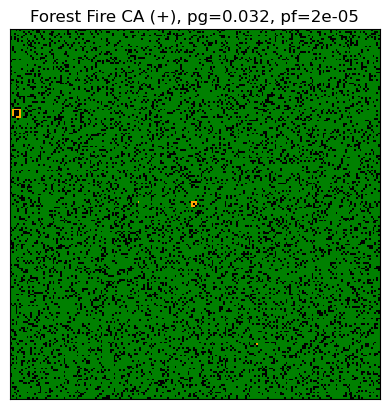

In [113]:

# ========== ЗАПУСК ==========
# if __name__ == "__main__":
ca = create_ca(w, h)
init_state(ca, eta, f)
nt =NeighborhoodType.CROSS if neigh.lower().startswith("cross") else NeighborhoodType.NEUMAN
st = simulate(ca, nt, time=200)

# --- Анимация ---
fig, ax = plt.subplots()
ax.set_title(f"Forest Fire CA ({nt.value}), pg={p_g}, pf={p_f}")
ax.set_xticks([]); ax.set_yticks([])
im = ax.imshow(ca, cmap=cmap_forest, vmin=0, vmax=2, interpolation="nearest")

def update_anim(fracame):
    global ca
    ca = update(ca, nt)
    im.set_data(ca)
    return [im]

ani = animation.FuncAnimation(fig, update_anim, frames=sim_time, interval=100, blit=True)
# plt.show()

# --- Графики статистики после симуляции ---


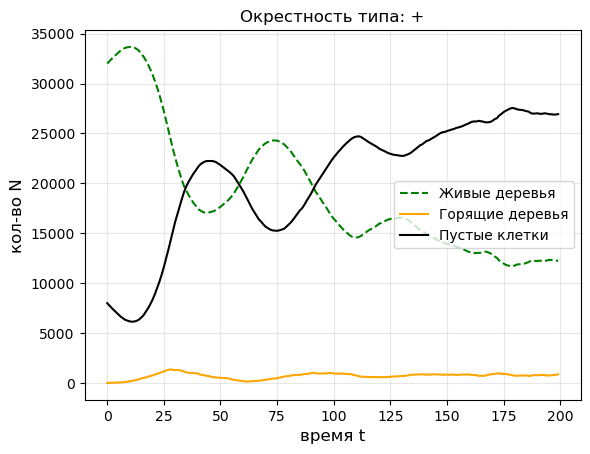

In [115]:
# plt.plot(st.t, st.a_t, 'r--', st.t, st.a_f, 'b--', st.t, st.a_e, 'g--')
# plt.legend(
# plt.show()
# st = simulate(ca, NeighborhoodType.CROSS, time=500)
ca = create_ca(w, h)
init_state(ca, eta, f)
nt =NeighborhoodType.CROSS if neigh.lower().startswith("cross") else NeighborhoodType.NEUMAN
st = simulate(ca, nt, time=200)

fig, ax = plt.subplots()
fig
lines = ax.plot(st.t, st.a_t, 'g--', st.t, st.a_f, 'orange', st.t, st.a_e, 'black')
plt.grid(True, alpha=0.3)
plt.title('Окрестность типа: +')
plt.xlabel('время t', fontsize=12)
plt.ylabel('кол-во N', fontsize=12)
ax.legend(['Живые деревья', 'Горящие деревья', 'Пустые клетки'], loc='center right')
plt.show()

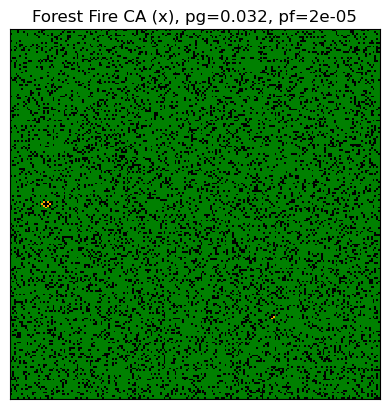

In [116]:
neigh =''
ca = create_ca(w, h)
init_state(ca, eta, f)
nt =NeighborhoodType.CROSS if neigh.lower().startswith("cross") else NeighborhoodType.NEUMAN

# --- Анимация ---
fig, ax = plt.subplots()
ax.set_title(f"Forest Fire CA ({nt.value}), pg={p_g}, pf={p_f}")
ax.set_xticks([]); ax.set_yticks([])
im = ax.imshow(ca, cmap=cmap_forest, vmin=0, vmax=2, interpolation="nearest")

def update_anim(fracame):
    global ca
    ca = update(ca, nt)
    im.set_data(ca)
    return [im]

ani = animation.FuncAnimation(fig, update_anim, frames=sim_time, interval=100, blit=True)
# plt.show()

# --- Графики статистики после симуляции ---

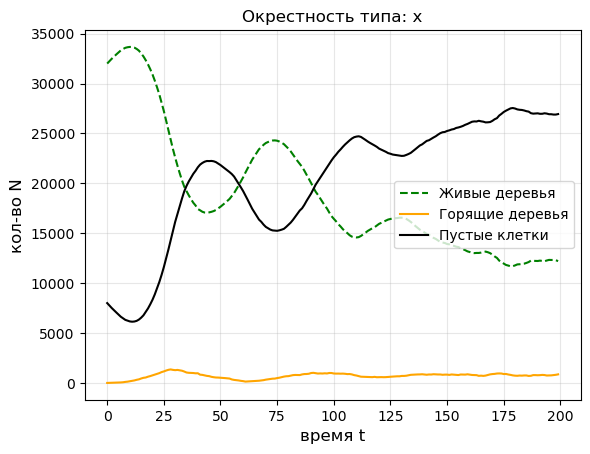

In [117]:
# plt.plot(st.t, st.a_t, 'r--', st.t, st.a_f, 'b--', st.t, st.a_e, 'g--')
# plt.legend(
# plt.show()

fig, ax = plt.subplots()
fig
lines = ax.plot(st.t, st.a_t, 'g--', st.t, st.a_f, 'orange', st.t, st.a_e, 'black')
plt.grid(True, alpha=0.3)
plt.title('Окрестность типа: x')
plt.xlabel('время t', fontsize=12)
plt.ylabel('кол-во N', fontsize=12)
ax.legend(['Живые деревья', 'Горящие деревья', 'Пустые клетки'], loc='center right')
plt.show()

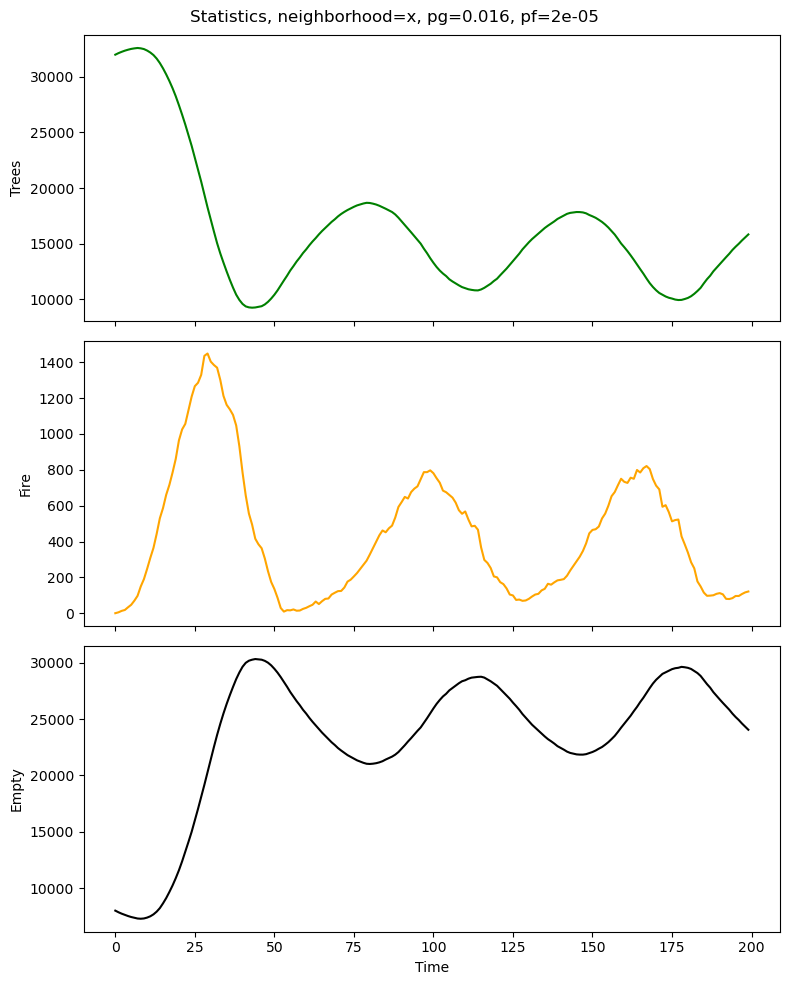

In [70]:
fig, ax = plt.subplots(3, 1, figsize=(8, 10), sharex=True)

ax[0].plot(st.t, st.a_t, color="green")
ax[0].set_ylabel("Trees")

ax[1].plot(st.t, st.a_f, color="orange")
ax[1].set_ylabel("Fire")

ax[2].plot(st.t, st.a_e, color="black")
ax[2].set_ylabel("Empty")
ax[2].set_xlabel("Time")

fig.suptitle(f"Statistics, neighborhood={nt.value}, pg={p_g}, pf={p_f}")
plt.tight_layout()
plt.show()